## Lesson 1: Tracer transport operators I
To model marine biogeochemical processes on a global scale we need to be able to account for the movement of chemical constituents both horizontally and vertically. We do this with a <b><i>tracer transport operator</i></b>.  When this operator acts on a tracer field it produces the advective-diffusive divergence of the tracer.

In order to represent the transport operator on a computer we have to discretize the tracer concentration field and the operator.  Once discretized the tracer field is represented as a vector and the operator is represented as a sparse matrix. (A sparse matrix behaves the same way as a regular matrix. The only difference is that in a sparse matrix the majority of the entries are zeros. These zeros are not stored explicitly to save computer memory making it possible to deal with fairly high resolution ocean models. 

Mathematically, the discretization converts an expression with partial derivatives into a matrix vector product:

$$\nabla \cdot \left[\mathbf{u}-\mathbf{K}\cdot\nabla \right]C \longrightarrow \mathbf{T}\mathbf{c}$$

where $\mathbf{T}$ is the flux divergence transport matrix and $\mathbf{c}$ is the tracer concentration vector. 

One can go a long way towards understanding what a tracer transport operator is by playing with a simple box model. We therefore introuce a simple box model before moving on to the <i>Ocean Circulation Inverse Model</i> (OCIM).


The simple box model we consider is embeded in a $2\times2\times2$ "shoebox". It has 5 <i>wet</i> boxes and 3 <i>dry</i> boxes.
<img src="boxmodel.png" width =800>

In [64]:
a = 6367e3   # Earth radius           (m)
A = 4*pi*a^2 # Earth surface area     (m²)
d = 3700     # ocean depth            (m)
V = 0.75*A*d # volume of ocean        (m³)
h = 200      # thickness of top layer (m)

dz = [h*ones(4,1);(d-h)*ones(4,1)] # grid box thicknesses       (m)
dV = (dz/d).*((V/4)*ones(8,1))     # grid box volumes           (m³)
dAz = dV./dz                       # area of face ⟂ to z axis   (m²)
dy = sqrt.(dAz)                    # north-south side length    (m)
dx = sqrt.(dAz)                    # east-west side length      (m)
dAx = dV./dy                       # area of face ⟂ to x axis   (m²)
dAy = dV./dx                       # area of face ⟂ to y axis   (m²)

msk = [1, 1, 1, 0, 1, 1, 0, 0]     # wet-dry mask wet=1 dry = 0 
iwet = findall(x -> x == 1, msk)        # index to wet gridboxes
idry = findall(x -> x == 0, msk)        # index to dry gridboxes
srf = [1, 1, 1, 0, 0]              # surface mask srface=1 bottom = 0
isrf = findall(x -> x == 1, srf) ;
iwet

5-element Array{Int64,1}:
 1
 2
 3
 5
 6

The circulation consists of 
<ul>
    <li>a meridional overturning circulation flowing from box 1 to box 2 to box 6 to box 5 and back to box 1</li>
    <li>a zonal current in a reentrant channel from box 1 to box 3 and back to box 1</li>
    <li>vertical mixing representing deep convection between box 2 and box 6</li>
</ul>
    

In [2]:
using LinearAlgebra
using SparseArrays
TRdiv = spzeros(8,8)
# "Antarctic Circumpoloar Current" flow out minus flow in 
acc = 100e6  # (m³/s)
TRdiv += sparse([1,1],[1,3],dV[1]\[acc,-acc],8,8)
TRdiv += sparse([3,3],[3,1],dV[3]\[acc,-acc],8,8)
# "Meridional Overturning Circulation" flow out minus flow in
moc = 15e6    # (m³/s)
TRdiv += sparse([1,1],[1,5],dV[1]\[moc,-moc],8,8)
TRdiv += sparse([2,2],[2,1],dV[2]\[moc,-moc],8,8)
TRdiv += sparse([5,5],[5,6],dV[5]\[moc,-moc],8,8)
TRdiv += sparse([6,6],[6,2],dV[6]\[moc,-moc],8,8)
# vertical mixing at "high northern latitudes" flow out minus flow in
q = 10e6      # (m³/s)
TRdiv += sparse([2,2],[2,6],dV[2]\[q,-q],8,8)
TRdiv += sparse([6,6],[6,2],dV[6]\[q,-q],8,8)
TRdiv = TRdiv[iwet,iwet]
Matrix(TRdiv)

5×5 Array{Float64,2}:
  6.01987e-9   0.0         -5.23467e-9  -7.852e-10     0.0        
 -7.852e-10    1.30867e-9   0.0          0.0          -5.23467e-10
 -5.23467e-9   0.0          5.23467e-9   0.0           0.0        
  0.0          0.0          0.0          4.48686e-11  -4.48686e-11
  0.0         -7.4781e-11   0.0          0.0           7.4781e-11 

## An idealized radiocarbon simulation
Radiocarbon, <sup>14</sup>C, is produced by cosmic rays in the lower stratosphere and upper troposphere. It quickly reacts with oxygen to produce <sup>14</sup>CO<sub>2</sub>, which is then mixed throughout the troposphere and enters the ocean through air-sea gas exchange. Because the halflife of radiocarbon is only 5730 years a significant amount of deday can occur before the dissolved inorganic radiocarbon (DI<sup>14</sup>C) can mix uniformally throughout the ocean. As such the <sup>14</sup>C serves as a tracer label for water that was recently in contact with the atmosphere. 

Here we will perform an idealized radiocarbon simulation in our model. In this model we prescribe the atmospheric concentration to 1 and model the air-sea gas exchange using a constant piston velocity of $\kappa = $50m/10years. For the radioactive decay we use a timescale of $\tau =$(5730 years)/$\log(2)$.

In [3]:
sec_per_year = 365*24*60*60; 
κ = 50/(10*sec_per_year)     # m/s
λ  = 1/(5730*sec_per_year/log(2)); # 1/s

In [4]:
M = TRdiv
Λ = spdiagm(0=>srf)/h         # air-sea loss operator
M += κ*Λ                     
I = spdiagm(0=>ones(5))       # identity matrix
M += λ*I  # radioactive decay loss operator
s = κ*Λ*ones(5);             # air-sea source rate

We now have a governing equation of the form
$$ \frac{dR}{dt} + \left[\mathbf{T}+\lambda\mathbf{I}+\kappa\boldsymbol{\Lambda}\right]R = \kappa\boldsymbol{\Lambda}\mathbf{1}$$.

## Simple Euler backward time stepper

In [23]:
function euler_backward(J,s,tspan,x0,n)
    # solve dx/dt=F(x) from tspan[1] to tspan[2] subject to x[tspan[1]] = x0
    # using the Euler backward scheme with n timesteps
    # (x[i+1]-x[i])/dt = J*X[i+1] + s
    dt = (tspan[2]-tspan[1])/(n-1);
    I = spdiagm(0=>ones(length(x0)))
    A = I-dt.*J
    X = zeros(5,n)
    T = zeros(n)
    X[:,1] = x0
    T[1] = tspan[1]
    for i in 2:n
        X[:,i] = A\(X[:,i-1]+dt.*s)
        T[i] = T[i-1]+dt
    end
    return X,T
end

euler_backward (generic function with 1 method)

In [62]:
tspan = zeros(2)
tspan[1] = 0
tspan[2] = 7500;
x0 = 0*s.+1
X,T = euler_backward(-sec_per_year*M,sec_per_year*s,tspan,x0,10000)

([1.0 0.999911 … 0.939696 0.939696; 1.0 0.999911 … 0.952269 0.952269; … ; 1.0 0.999909 … 0.834544 0.834544; 1.0 0.999909 … 0.90582 0.90582], [0.0, 0.750075, 1.50015, 2.25023, 3.0003, 3.75038, 4.50045, 5.25053, 6.0006, 6.75068  …  7493.25, 7494.0, 7494.75, 7495.5, 7496.25, 7497.0, 7497.75, 7498.5, 7499.25, 7500.0])

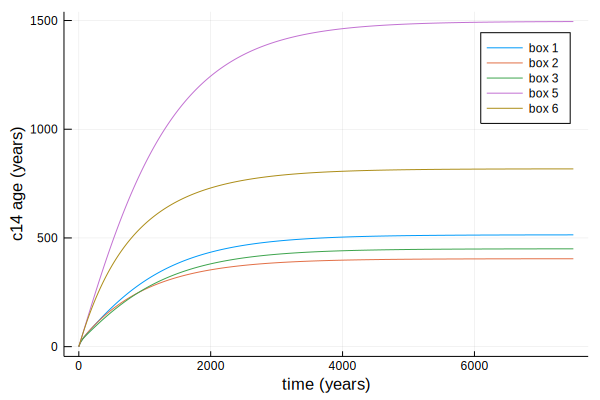

In [74]:
using Plots, Printf
c14age = -log.(X)./(λ*sec_per_year)
labels = [@sprintf("box %i",iwet[i]) for i in 1:5]
plot(T,c14age',label = labels)
xlabel!("time (years)")
ylabel!("c14 age (years)")

The box model took more than 4000 years to spin up to equilibrium. For a box model that's no big deal because it is not computationally expensive to run the model, but for a big circulation model waiting for the model to spinup is painful.  We therefore want a better way to find the equilibrium solution.

One thing we notice is that when the model is at equilibrium, the $dR/dt$ term vanishes and 
the steady state solution is given by the solution to the following linear system of equations
$$ \underbrace{\left[\mathbf{T}+\lambda\mathbf{I}+\kappa\boldsymbol{\Lambda}\right]}_{=\equiv\mathbf{M}}R = \underbrace{\kappa\boldsymbol{\Lambda}\mathbf{1})}_{\equiv s}$$
which can be solved by directly inverting the $M$ matrix.

In [5]:
R = M\s;

In [6]:
c14age = -log.(R)/(λ*sec_per_year);
for i in 1:5 @printf("box[%i]: %4.0f years\n",iwet[i],c14age[i]) end


box[1]:  514 years
box[2]:  404 years
box[3]:  450 years
box[5]: 1496 years
box[6]:  818 years


Try modifying the strength of the currents of the high latitude convective mixing to see how it affects the <sup>14</sup>C-ages.